In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from mltool.eda import plot_cor, missing_percentage
from mltool.process import reduce_mem_usage

import matplotlib
matplotlib.rcParams[u'font.sans-serif'] = ['Taipei Sans TC Beta']
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# 資料導入
* 修正欄位名稱 (包含空格)
* 降低記憶體使用

In [2]:
df = pd.read_csv('./data/OnlineNewsPopularity.csv')
df.columns = [x.strip() for x in df.columns]
df = reduce_mem_usage(df)

Mem. usage decreased to  5.52 Mb (70.1% reduction)


In [3]:
df.head(3)

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663574,1.0,0.815430,4.0,2.0,1.0,...,0.099976,0.700195,-0.350098,-0.600098,-0.199951,0.5,-0.1875,0.0,0.1875,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604980,1.0,0.791992,3.0,1.0,1.0,...,0.033325,0.700195,-0.118774,-0.125000,-0.099976,0.0,0.0000,0.5,0.0000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575195,1.0,0.664062,3.0,1.0,1.0,...,0.099976,1.000000,-0.466553,-0.799805,-0.133301,0.0,0.0000,0.5,0.0000,1500


# 資料處理
## 定義目標特徵
* shares特徵 range 過大, 直接預測意義不大
* 定義熱門文章(hot_news): 分享數大於分享數的中位數(1400) 為1 其餘為0
* 丟棄shares特徵

Text(0.5, 1.0, 'shares log distribution')

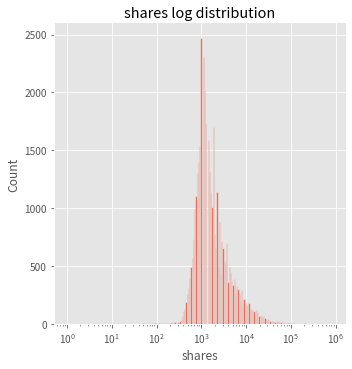

In [4]:
sns.displot(df['shares'],log_scale=True)
plt.title(f"shares log distribution")

In [5]:
df['hot_news'] = (df['shares']>1400).astype(int)
df.drop(columns=['shares'],inplace=True)

## 資料檢查
* 遺失值: 無
* 資料形態: 除了 url 外其餘皆為數值型

In [6]:
missing_percentage(df)

,Total,Percent


In [7]:
df.dtypes[df.dtypes!='float16']

url                            object
kw_max_min                    float32
kw_min_max                    float32
kw_max_max                    float32
kw_avg_max                    float32
kw_max_avg                    float32
self_reference_min_shares     float32
self_reference_max_shares     float32
self_reference_avg_sharess    float32
hot_news                        int64
dtype: object

In [30]:
df.hot_news.value_counts()

0    20082
1    19562
Name: hot_news, dtype: int64

In [31]:
df.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

## 特徵抽取
* url 含有標題以及日期資訊 是其他欄位所沒有的
    * 例如: 'http://mashable.com/2013/01/07/amazon-instant-video-browser/', '2013/01/07' 為新聞發布日期, 'amazon-instant-video-browser'為簡化的標題內容
* 其餘特徵為原始文章的敘述統計結果 以樹模型架構來說,難以繼續抽取特徵

In [8]:
import re

In [9]:
df[['year','month','day']] = df['url'].apply(lambda x : re.findall(r'\d{4}\/\d{2}\/\d{2}',x)[0]).str.split('/',expand=True).astype('int32')
df['title'] = df['url'].apply(lambda x: x.split('/')[-2].replace('-',' '))

# EDA
* 對數值型特徵觀察其相關係數
    * 對反應特徵(是否為熱門文章)來說與各應變特徵相關性不大, 很適合用模型配適
    * 少數應變特徵具有很高的相關度(下表數值經過四捨五入),在資料處理暫時不處理,樹模型在挑選特徵策略會有更準確的判斷
* 應變特徵與反應特徵關係
    * 雖然沒有很直接的關聯性,在某些變數 如:LDA_03,LDA_04,rate_positive_words...等等可看出在是否為熱門文章上有些分布差異

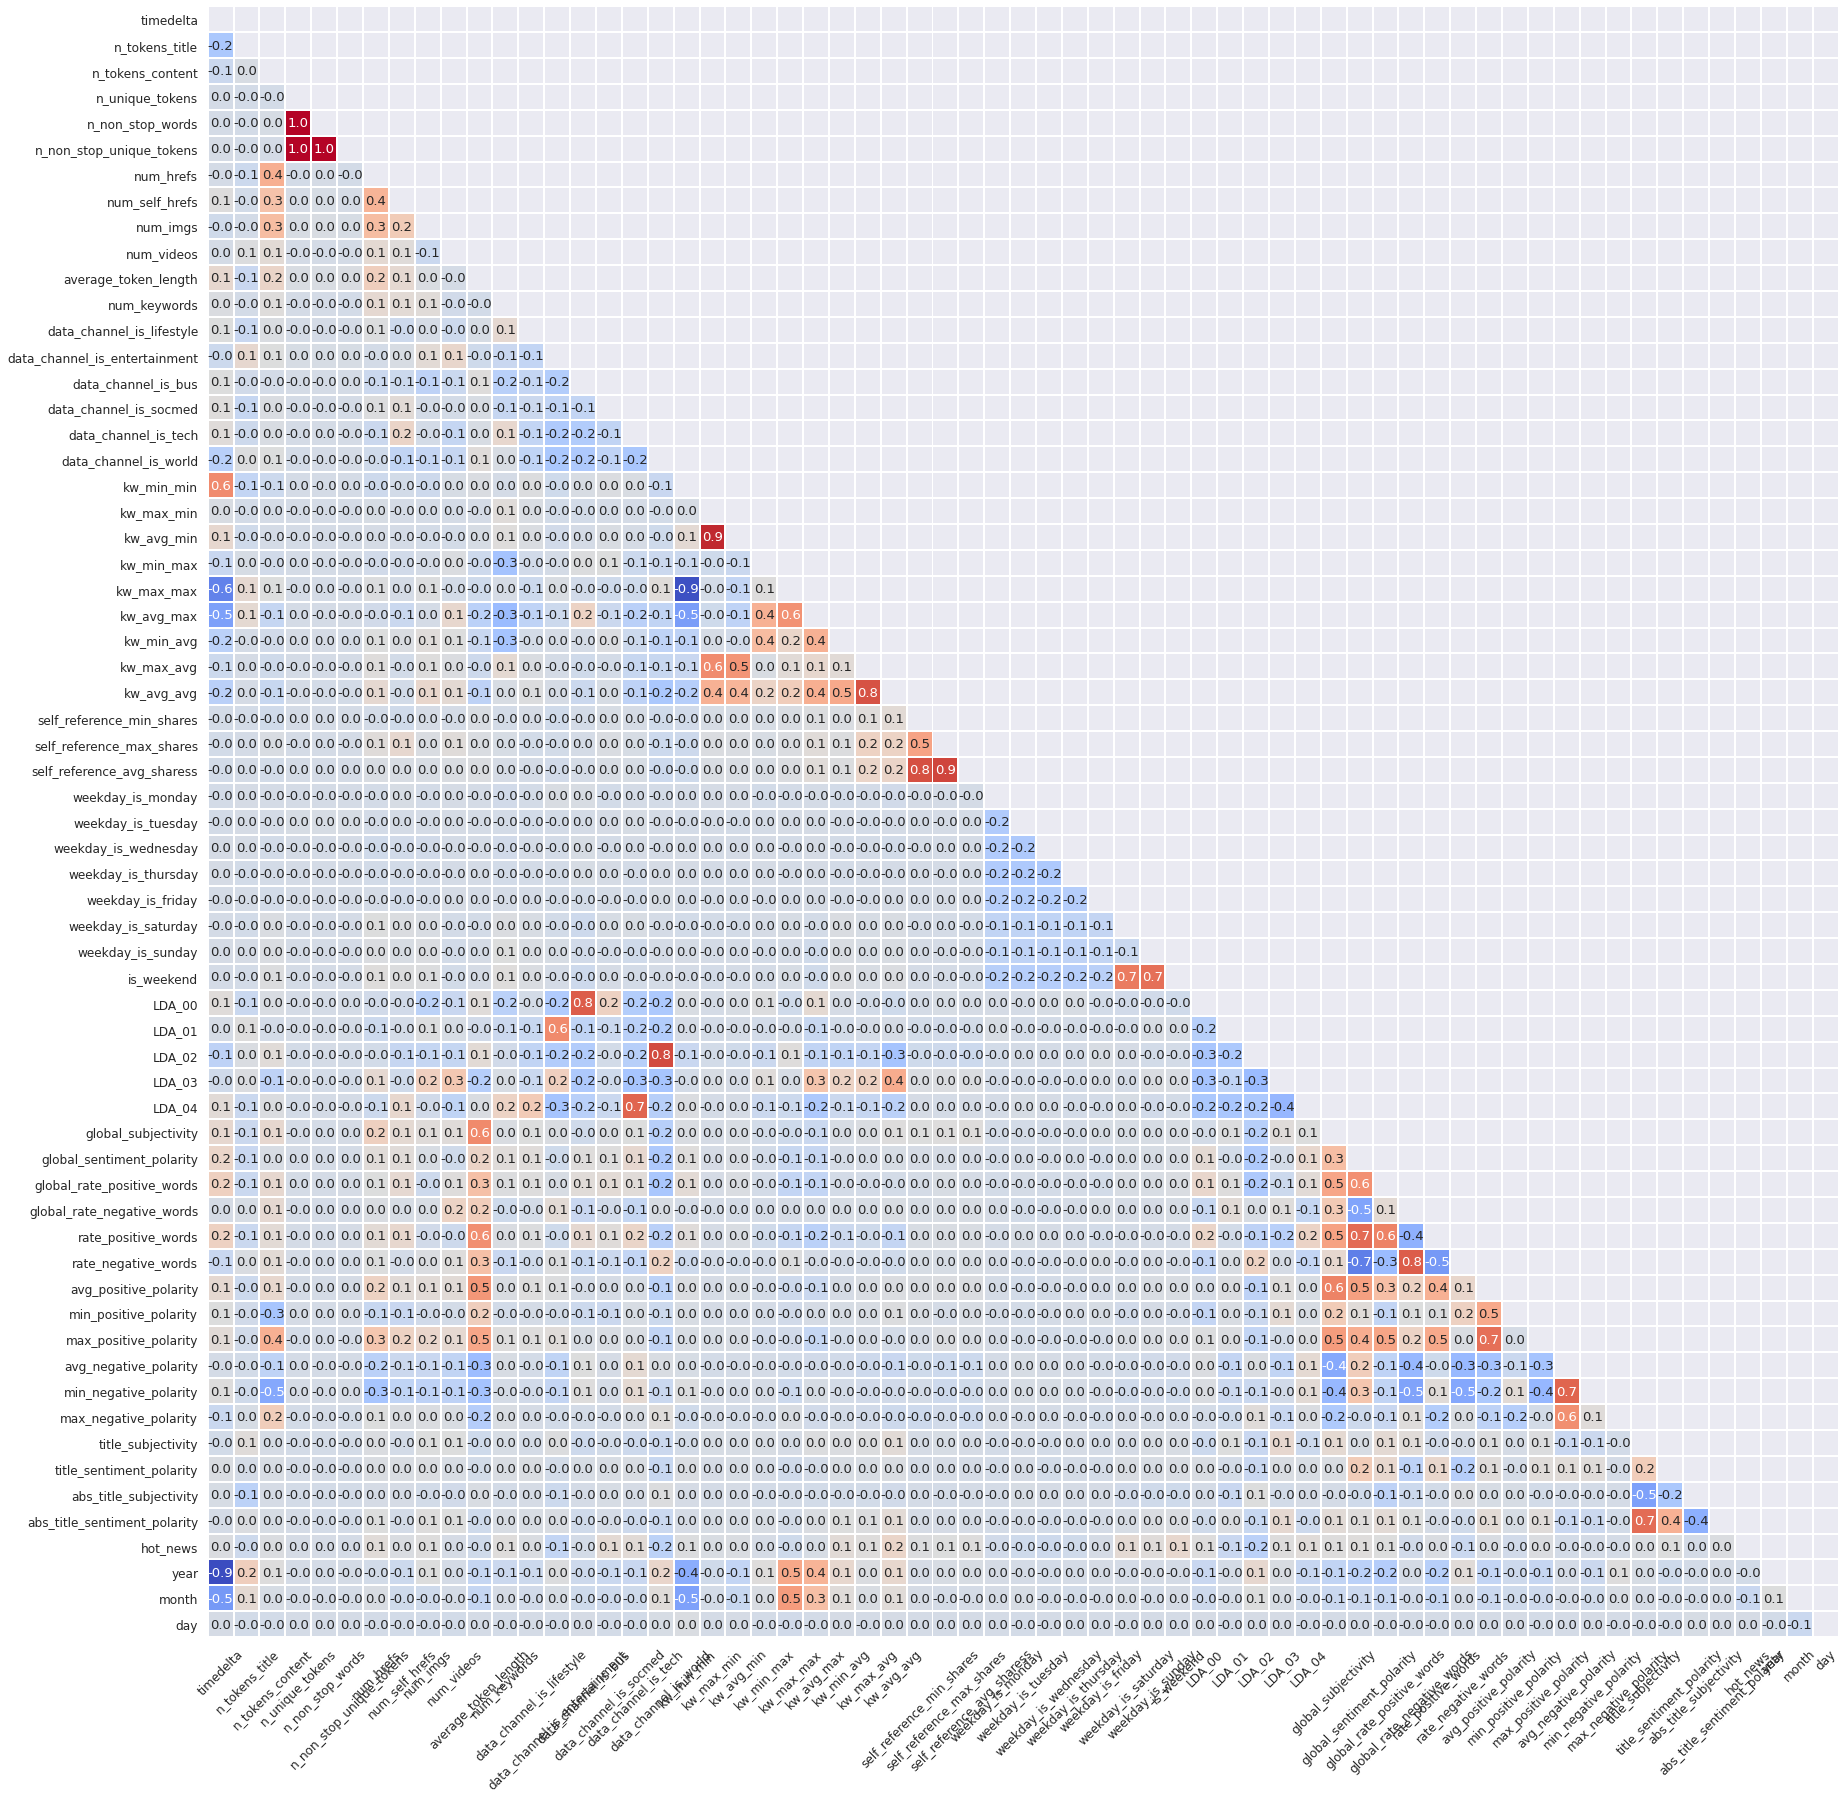

In [10]:
plot_cor(df, figsize=(30, 30))

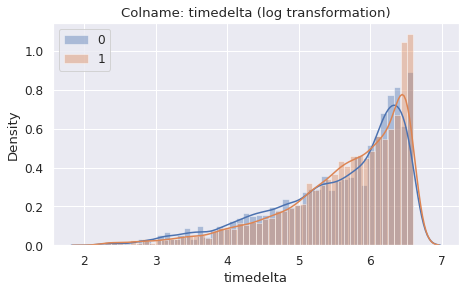

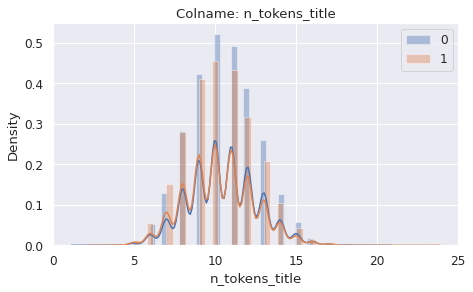

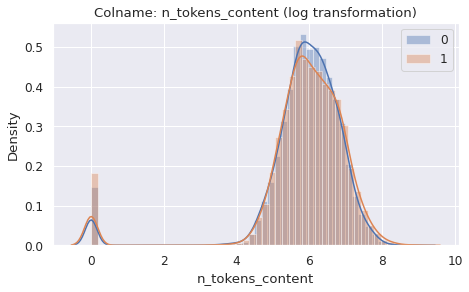

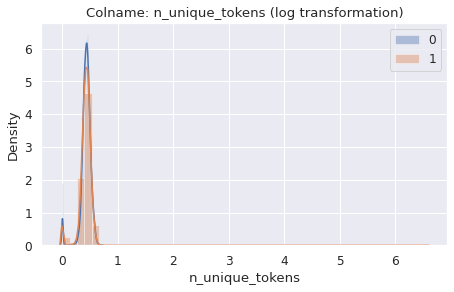

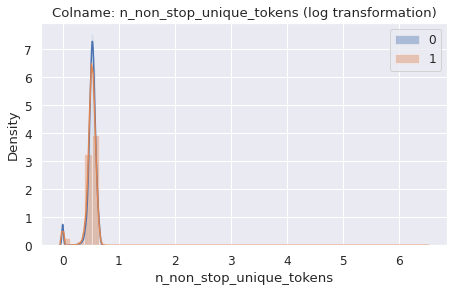

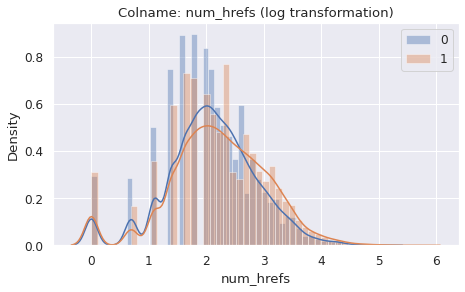

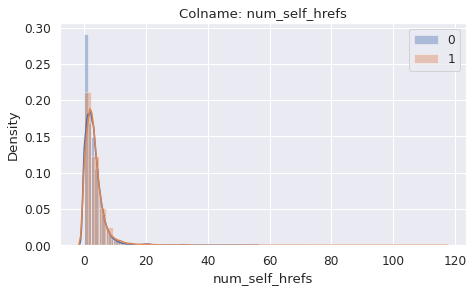

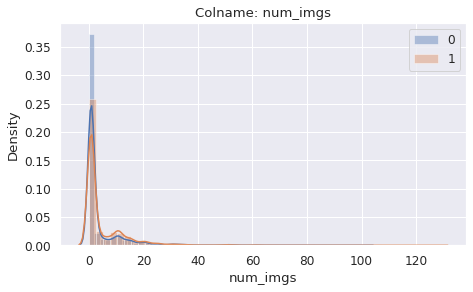

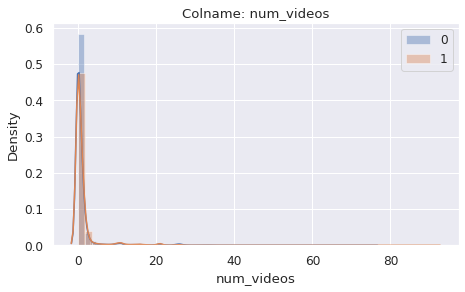

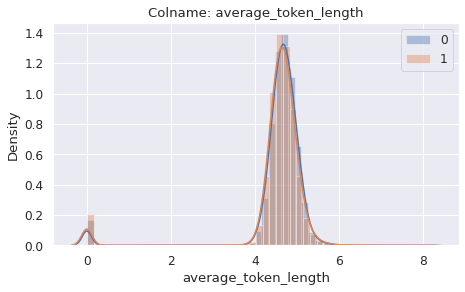

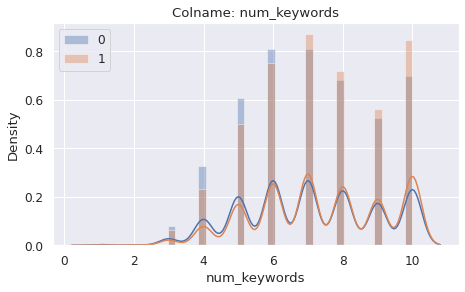

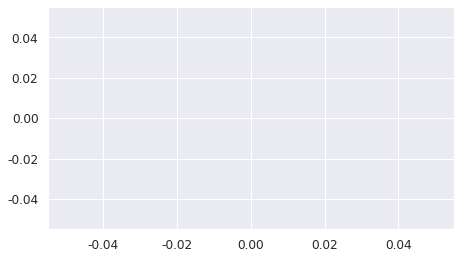

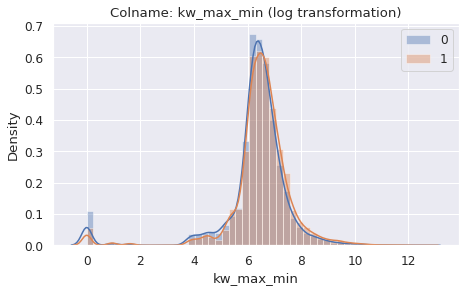

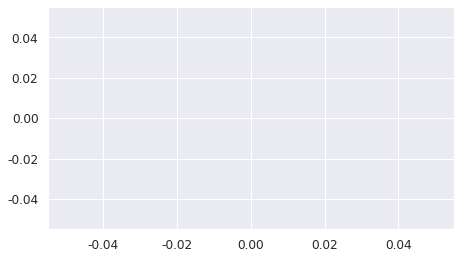

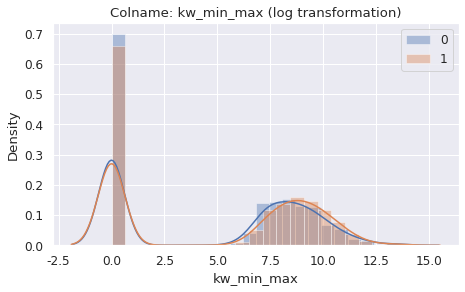

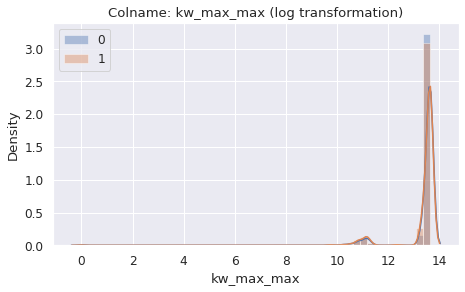

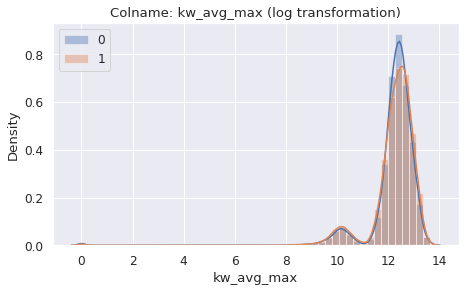

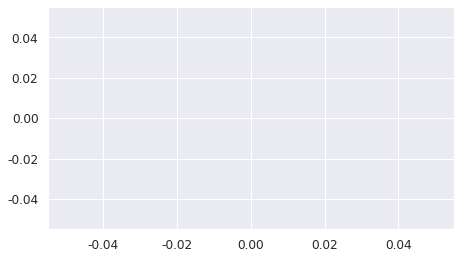

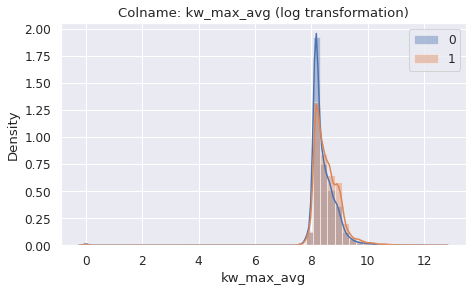

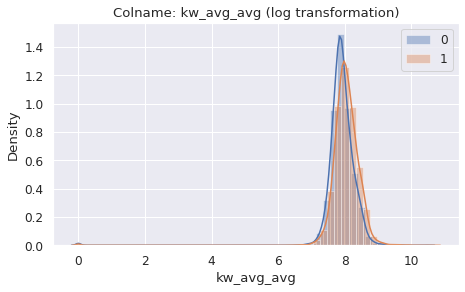

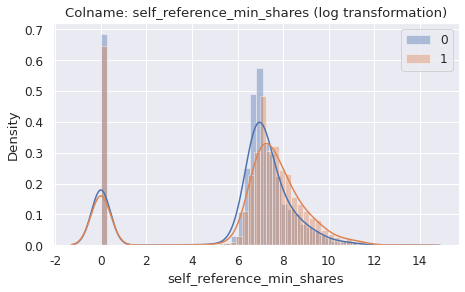

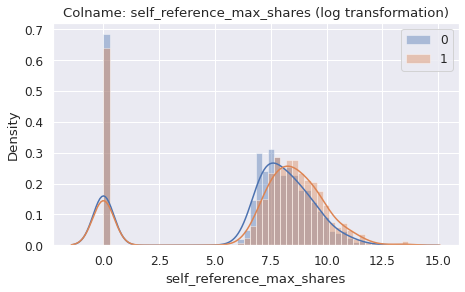

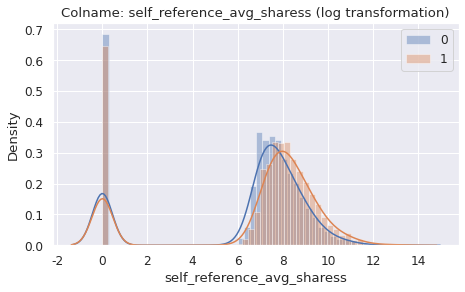

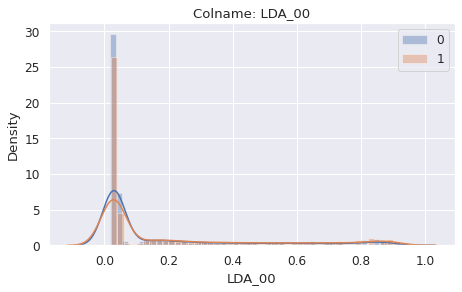

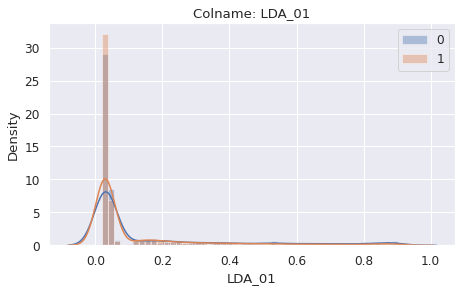

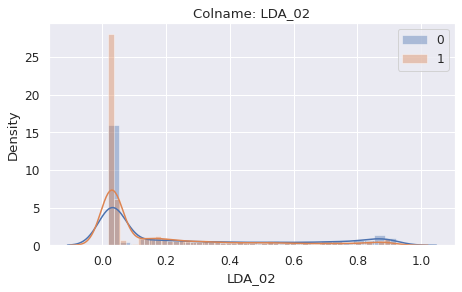

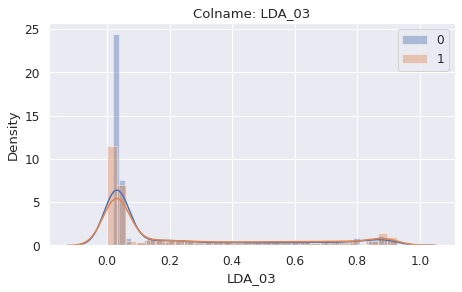

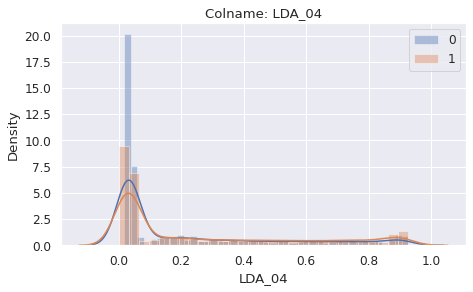

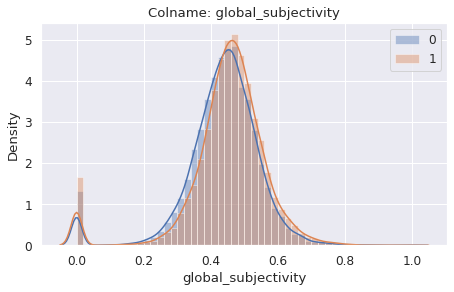

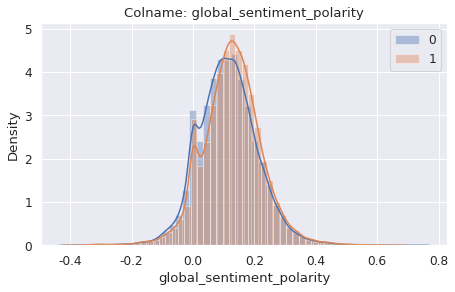

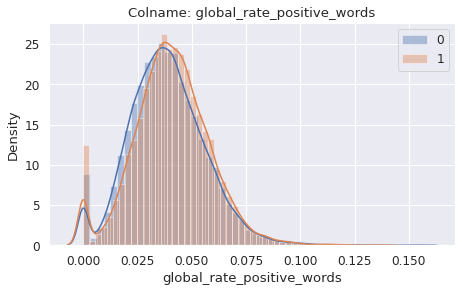

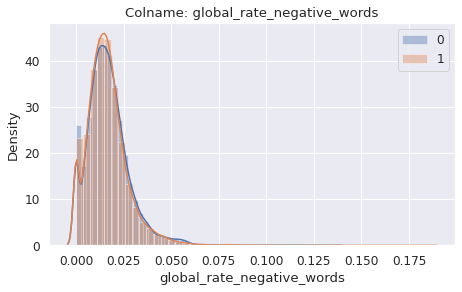

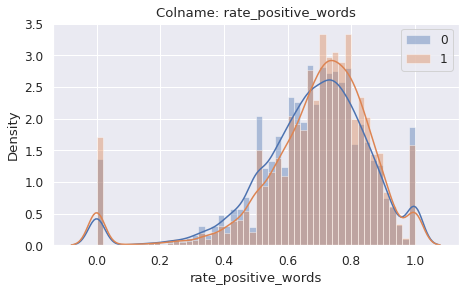

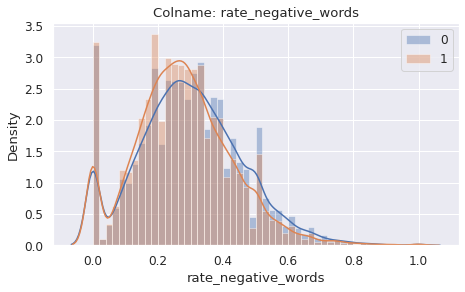

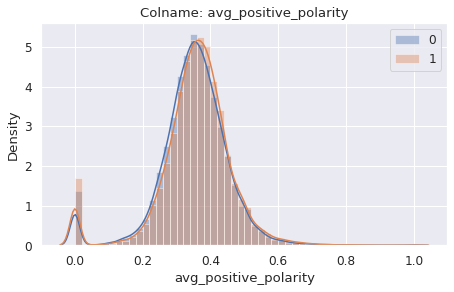

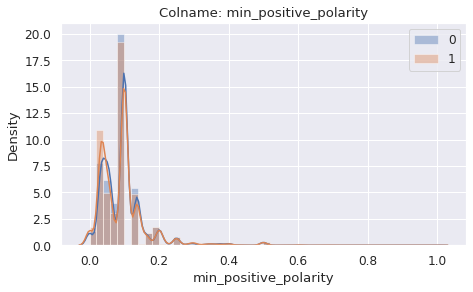

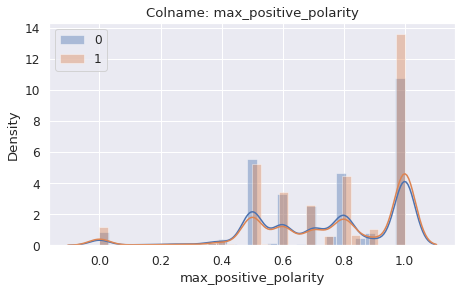

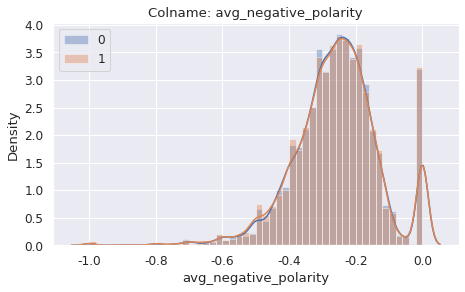

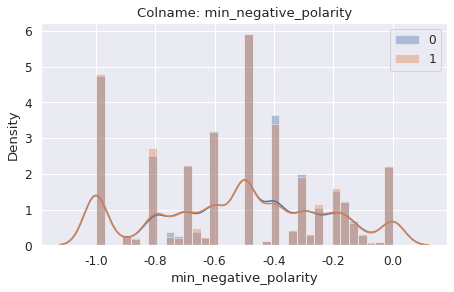

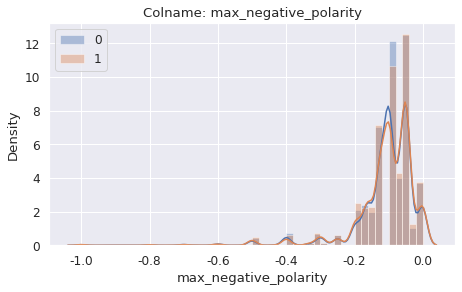

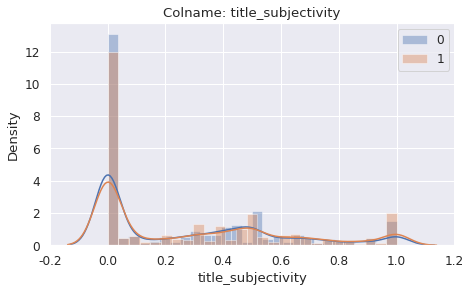

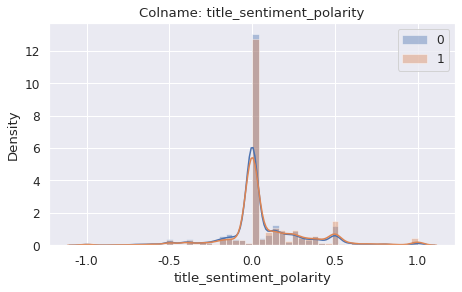

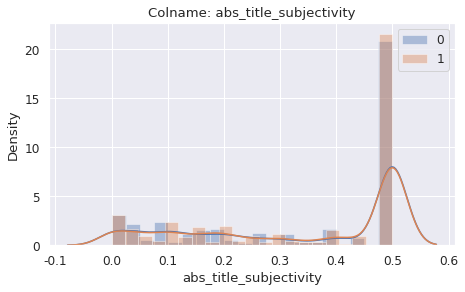

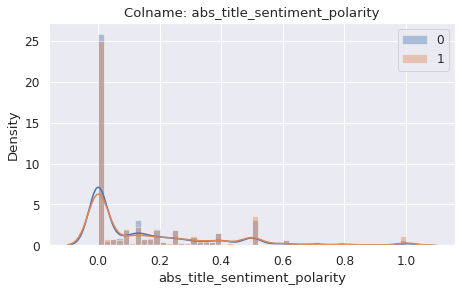

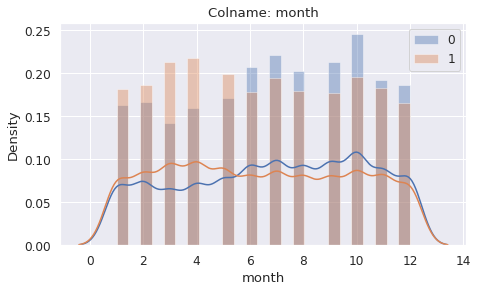

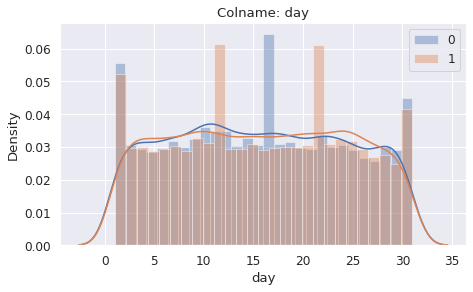

In [11]:
#relation between covariate variable and response variable
exceptlist = []
for k in df.columns:
    if (len(df[k].unique())>5)  & (df.dtypes!='object')[k] & (k!='hot_news'):
        try:
            fig = plt.figure(figsize=(16,9))
            ax1 = fig.add_subplot(221)
            if df[k].max()-df[k].min() >150:
                sns.distplot(np.log(df[k][df.hot_news==0]+1),label='0',ax=ax1)
                sns.distplot(np.log(df[k][df.hot_news==1]+1),label='1',ax=ax1)
                plt.legend()
                plt.title(f"Colname: {k} (log transformation)")
            else:
                sns.distplot(df[k][df.hot_news==0],label='0',ax=ax1)
                sns.distplot(df[k][df.hot_news==1],label='1',ax=ax1)
                plt.legend()
                plt.title(f"Colname: {k}")
        except:
            pass #print('{}: type error -- {}'.format(k,df[k].dtypes))
    elif k=='shares':
        continue
    else:
        exceptlist.append(k)

## 額外特徵抽取
* 因為這類型特徵會影響實際狀況的預測結果,考量到未來預測文章有時序性,所以先將資料依據時間切分為訓練集和測試集
* 透過TF-IDF先取得標題的詞向量, 再用LDA將標題向量聚類

Text(0.5, 1.0, 'timedelta 分布')

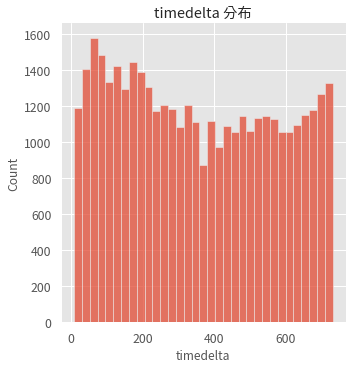

In [34]:
sns.displot(df['timedelta'])
plt.title('timedelta 分布')

In [13]:
df_train = df[df['timedelta']>150].copy()
df_valid = df[df['timedelta']<150].copy()

In [14]:
print(f'訓練集 資料量: {df_train.shape[0]}')
print(f'測試集 資料量: {df_valid.shape[0]}')

訓練集 資料量: 30581
測試集 資料量: 8993


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

no_features = 100
no_dimension = 5

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,1),
                                   max_features=no_features, 
                                   stop_words = 'english')

tfidf_train = tfidf_vectorizer.fit_transform(df_train['title'])
tfidf_valid = tfidf_vectorizer.transform(df_valid['title'])

In [16]:
#LDA
lda = LatentDirichletAllocation(n_components=no_dimension, 
                                max_iter=50,
                                learning_method='batch', 
                                learning_offset=50., 
                                random_state=0,
                                n_jobs = 20)

lda_train = lda.fit_transform(tfidf_train)
lda_valid = lda.transform(tfidf_valid)

In [17]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]),'\n')

print(f"LDA 分群 Top 5 代表字:\n" + '=='*20)
display_topics(lda , tfidf_feature_names , 5)

LDA 分群 Top 5 代表字:
Topic 0:
video apple world samsung 2014 

Topic 1:
iphone social instagram media vine 

Topic 2:
facebook comic tech day youtube 

Topic 3:
google app ad game glass 

Topic 4:
twitter new apps photos tv 



In [18]:
df_train['title_lda'] = np.argmax(lda_train,axis=1)
df_valid['title_lda'] = np.argmax(lda_valid,axis=1)

In [19]:
df_train.groupby(['title_lda','hot_news'])['url'].count()

title_lda  hot_news
0          0           8529
           1           8570
1          0           1713
           1           1751
2          0           1842
           1           2092
3          0           1346
           1           1483
4          0           1616
           1           1639
Name: url, dtype: int64

In [20]:
df_train.columns

Index(['url', 'timedelta', 'n_tokens_title', 'n_tokens_content',
       'n_unique_tokens', 'n_non_stop_words', 'n_non_stop_unique_tokens',
       'num_hrefs', 'num_self_hrefs', 'num_imgs', 'num_videos',
       'average_token_length', 'num_keywords', 'data_channel_is_lifestyle',
       'data_channel_is_entertainment', 'data_channel_is_bus',
       'data_channel_is_socmed', 'data_channel_is_tech',
       'data_channel_is_world', 'kw_min_min', 'kw_max_min', 'kw_avg_min',
       'kw_min_max', 'kw_max_max', 'kw_avg_max', 'kw_min_avg', 'kw_max_avg',
       'kw_avg_avg', 'self_reference_min_shares', 'self_reference_max_shares',
       'self_reference_avg_sharess', 'weekday_is_monday', 'weekday_is_tuesday',
       'weekday_is_wednesday', 'weekday_is_thursday', 'weekday_is_friday',
       'weekday_is_saturday', 'weekday_is_sunday', 'is_weekend', 'LDA_00',
       'LDA_01', 'LDA_02', 'LDA_03', 'LDA_04', 'global_subjectivity',
       'global_sentiment_polarity', 'global_rate_positive_words',
     

# 模型建立 

In [21]:
use_col = [x for x in df_train.columns if x not in ['url','title','year','hot_news'] ]

cat_feature = ['data_channel_is_lifestyle','data_channel_is_entertainment', 'data_channel_is_bus','data_channel_is_socmed', 
               'data_channel_is_tech','data_channel_is_world','weekday_is_monday', 'weekday_is_tuesday','weekday_is_wednesday', 
               'weekday_is_thursday', 'weekday_is_friday','weekday_is_saturday', 'weekday_is_sunday', 'is_weekend','title_lda']

In [22]:
import lightgbm as lgb

lgb_train = lgb.Dataset(df_train[use_col], label = df_train['hot_news'])
lgb_valid = lgb.Dataset(df_valid[use_col], label = df_valid['hot_news'])

In [23]:
params = {
    'metric': 'binary',
    'seed': 123,
    'learning_rate' : 0.03,
    'lambda': 0.1,
    'num_leaves': 70,        
    #'device':'gpu',
    'bagging_freq' : 1,
    'sub_row' : 0.8,
    'force_row_wise' : True,
    'colsample_bytree': 0.7
}

lgb_model = lgb.train(params,
                      lgb_train, 
                      categorical_feature=cat_feature,
                      num_boost_round = 500, 
                      valid_sets = [lgb_valid],
                      early_stopping_rounds = 200,
                      verbose_eval = 100)

[LightGBM] [Info] Total Bins 8494
[LightGBM] [Info] Number of data points in the train set: 30581, number of used features: 62
[LightGBM] [Info] Start training from score 0.507995
Training until validation scores don't improve for 200 rounds
[100]	valid_0's binary_logloss: 0.601065
[200]	valid_0's binary_logloss: 0.597712
[300]	valid_0's binary_logloss: 0.598498
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.597307


In [24]:
def eval_res(model,data,ans,thres=0.5):
    prob = model.predict(data)
    pred = (prob>thres).astype('int')
    return (pred==ans).mean()

In [25]:
print('Train Acc:' ,eval_res(lgb_model,df_train[use_col],df_train['hot_news'],0.5))
print('Valid Acc:' ,eval_res(lgb_model,df_valid[use_col],df_valid['hot_news'],0.5))

Train Acc: 0.7698571008142311
Valid Acc: 0.6774157678194151


100%|██████████| 100/100 [00:08<00:00, 11.34it/s]


Text(0, 0.5, 'Acc')

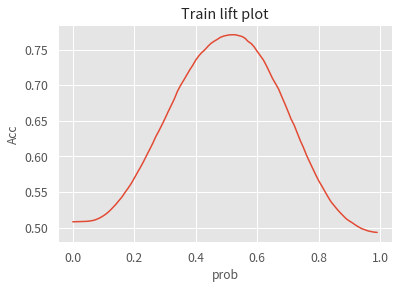

In [49]:
from tqdm import tqdm 

nrange = 100
acc_log = []
for i in tqdm(range(nrange)):
    acc_log.append(eval_res(lgb_model,df_train[use_col],df_train['hot_news'], i/nrange ))
plt.plot([x/nrange for x in range(nrange)],acc_log)
plt.title('Train lift plot')
plt.xlabel('prob')
plt.ylabel('Acc')

In [50]:
best_p = np.argmax(acc_log)/nrange
print(f'Train Acc for p={best_p} :' ,eval_res(lgb_model,df_train[use_col],df_train['hot_news'],best_p))
print(f'Valid Acc for p={best_p} :' ,eval_res(lgb_model,df_valid[use_col],df_valid['hot_news'],best_p))

Train Acc for p=0.52 : 0.7708054020470226
Valid Acc for p=0.52 : 0.6764149894362281


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

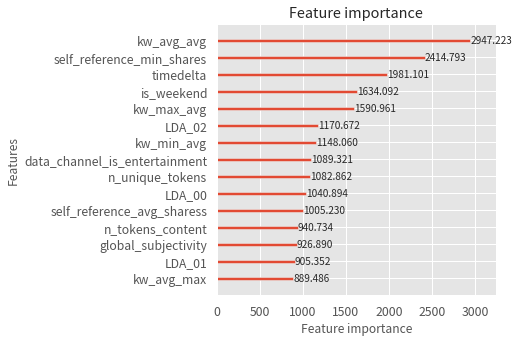

In [38]:
lgb.plot_importance(lgb_model, importance_type="gain", figsize=(5, 5),max_num_features=15)